<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/23.00.Aula-Cenario_Rio_Empresas.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Construção de cenários: definindo as idades](22.00.Aula-Construindo_Cenarios_Distribuicao_Idades.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# O cenário da cidade do Rio de Janeiro: rede de empresas

- Continuando a criação do cenário do Rio de Janeiro.

- Aqui, construímos a rede empresarial.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 09/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- Geramos e posicionamos as residências e os seus residentes, de acordo com os dados do [Landscan](https://landscan.ornl.gov) e com o censo residencial.

- Geramos as idades dos indivíduos.

### Carregando os dados do Landscan

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira. Isso reduz um pouco mais a população, mas preserva, essencialmente, a proporção entre as diferentes áreas da região.

In [6]:
pop_por_blocos = (landscan_rio/100).astype(int)
num_pop = pop_por_blocos.sum()

### Visualizando a distribuição populacional

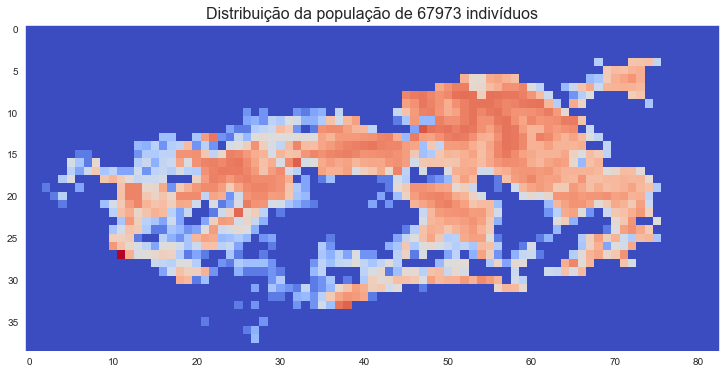

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_blocos), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {num_pop} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Censo residencial

Para fazer a distribuição das residências, precisamos de um "censo residencial", indicando as frações da população habitando residências de diferentes tamanhos.

Utilizaremos os seguintes valores, onde "Tamanho" é o tamanho da residência em número de residentes e "Porcentagem" é a porcentagem da população em residências do tamanho correspondente:

| Tamanho  | Porcentagem |
| --- | --- |
| 1 | 21% |
| 2 | 26% |
| 3 | 20% |
| 4 | 17% |
| 5 | 8% |
| 6 | 4% |
| 7 | 2% |
| 8 | 2% |


In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, .02])
num_tam_res = len(censo_residencial) # tamanho máximo

### Visualização do censo residencial

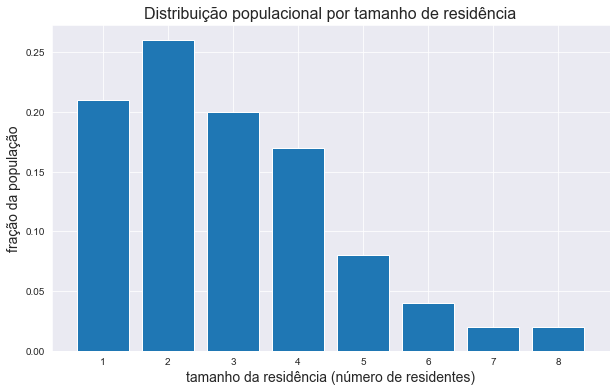

In [9]:
plt.figure(figsize=(10,6))
bar_width = 0.8
r1 = [j for j in range(1,num_tam_res+1)]
plt.bar(r1, censo_residencial, width=bar_width)
plt.xlabel('tamanho da residência (número de residentes)', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title(f'Distribuição populacional por tamanho de residência', fontsize=16)
plt.show()  

### Distribuindo e alocando os indivíduos e as suas residências

Aqui, usamos a função `episiming.cenarios.aloca_residencias_e_individuos()` discutida anteriormente.

In [10]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 1.24 s, sys: 35.7 ms, total: 1.28 s
Wall time: 1.36 s


### Gerando o grafo da rede residencial

In [11]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_blocos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 531 ms, sys: 41.2 ms, total: 572 ms
Wall time: 591 ms


### Viualização

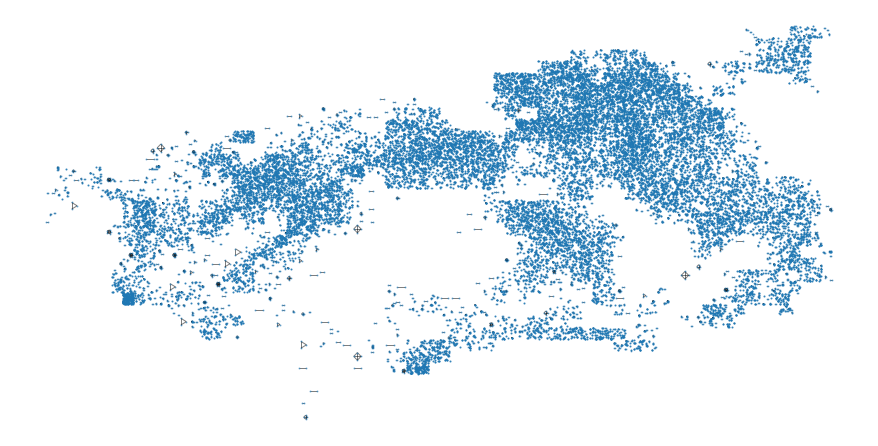

CPU times: user 2.04 s, sys: 41.8 ms, total: 2.08 s
Wall time: 2.1 s


In [12]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Definindo a idade dos indivíduos

Aqui, utilizamos a função criada a partir das discussões nas últimas notas.

### Pirâmide etária

Primeiro, precisamos de tabelas para a pirâmide etária.

In [13]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100

### Interpolando/extrapolando pirâmide

A partir da tabela, obtemos frações para cada ano, com a função `obtem_idades_fracoes()`

In [14]:
idades_fracoes = episiming.cenarios.obtem_idades_fracoes(idades_grupos, idades_fracoes_grupos, idade_max)

### Gerando as idades

In [15]:
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

### Visualizando a pirâmide populacional obtida

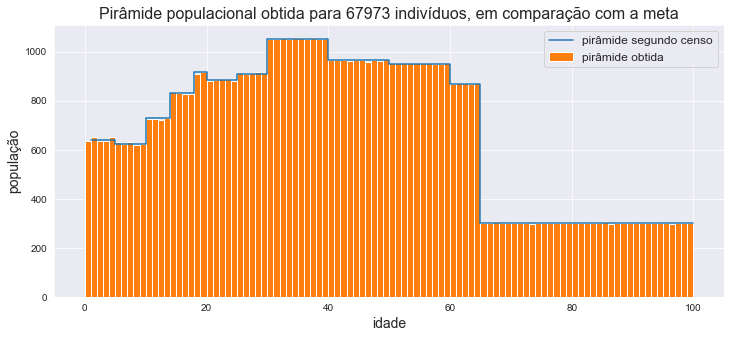

In [16]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Rede empresarial

Na construção da rede empresarial, a ideia é fazer os seguintes passos:

- Distribuir o número de empresas por tamanho da empresa seguindo uma distribuição na forma de uma lei de potência próxima a de uma [lei de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law), com parâmetros escolhidos de acordo com a população total e um número máximo de tamanho (ou médio?).

- Distribuir as empresas pelos blocos, com pesos de acordo com a população de cada bloco.

- Alocar os indivíduos em cada empresa, levando em consideração uma determinada distância média de deslocamento.

### Dados insuficientes disponíveis no Data.Rio

Em [Instituto Pereira Passos/Data.Rio - Estabelecimentos)](http://www.data.rio/datasets/estabelecimentos-mapa-participativo?geometry=-43.859%2C-23.032%2C-42.555%2C-22.810), é possível visualizar e baixar dados com a informação de alguns estabelecimentos na cidade do Rio de Janeiro, mas são muito poucos dados.

In [17]:
estabelecimentos_rio = np.load('../input/dados_rio/estabelecimentos.npy').astype(int)

In [18]:
print(f'Total de estabelecimentos: {estabelecimentos_rio.sum()}')

Total de estabelecimentos: 263


#### Distribuição espacial desses estabelecimentos

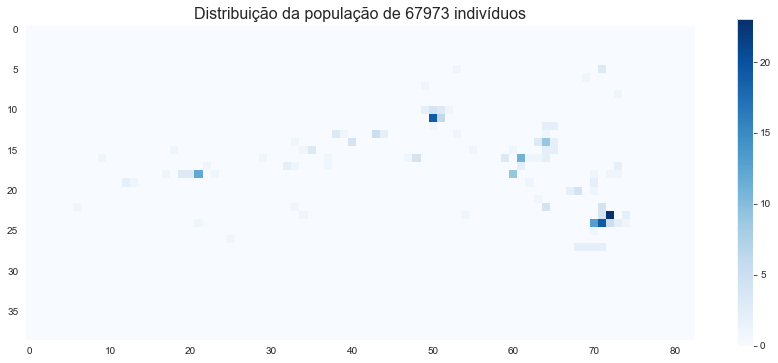

In [19]:
plt.figure(figsize=(15,6))
plt.imshow(estabelecimentos_rio, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuição das empresas por tamanho segundo o IBGE

Da página do IBGE com o [Cadastro Central de Empresas](https://cidades.ibge.gov.br/brasil/rj/rio-de-janeiro/pesquisa/19/0?indicador=29761), temos os seguintes dados globais para a cidade do Rio de Janeiro:

| Número de indivíduos ocupados | Número de empresas | Média de indivíduos por empresa |
| --- | --- | --- |
| 2.566.694 | 195.110 | 13,15 |

A página menciona, ainda, o número de indivíduos assalariados (2.269.964) e o número de "unidades locais" (209.237).

Uma pesquisa melhor é necessária para esclarecer os dados e, ainda, para ver se conseguimos detalhes sobre a distribuição espacial das empresas.

### Dimensionando as empresas via lei de potência

Conforme feito nos trabalhos do grupo do Imperial/Pitt, na falta de dados precisos, vamos distribuir o número de empresas por tamanho de acordo com uma lei de potência.

Vamos usar a mesma lei de potência, que é uma função com três parâmetros do tipo da [lei de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law).

#### Lei de potência do tipo Zipf com três parâmetros

- Aqui a lei de potência que eles usam para a distribuição da densidade de trabalhadores por tamanho do local de trabalho:

$$ \mathcal{P}(n > k) = f_3(k; a, c, k_\textrm{max}) 
= \frac{\displaystyle \left(\frac{\displaystyle 1 + \frac{k_\textrm{max}}{a}}{\displaystyle 1 + \frac{k}{a}}\right)^c - 1}{\displaystyle \left( 1 + \frac{k}{a}\right)^c -1}, \qquad 0 \leq k \leq k_\textrm{max}
$$

- Para a Tailândia, os parâmetros são $a = 3.26$, $c=0.97$ e $k_\textrm{max} = 2870$.

- Para os EUA e para a Grã-Bretanha, os parâmetros são $a = 5.36$, $c=1.34$ e $l_\textrm{max} = 5920$.

- Vale ressaltar que, segundo as [notas suplementares de Ferguson et al (2006)](#Referências),

    *US workplaces obey a power law distribution for the number of employees. However, as the model incorporates workplaces rather than firms, we used establishment size data... Independent data were not available for UK establishments, so US parameters were assumed.*

- Para o Rio de Janeiro ???

## População economicamente ativa

### Frações da população economicamente ativa por idade

In [20]:
pea_idades_grupos = np.array([0, 16, 18, 23, 50, 70, 100])
pea_idades_fator_grupos = np.array([0, 0.2, 0.75, 0.85, 0.75, 0.15, 0])

In [21]:
pea_idades_fator = list()
for j in range(len(pea_idades_grupos)-1):
    pea_idades_fator += (pea_idades_grupos[j+1] - pea_idades_grupos[j]) \
        * [pea_idades_fator_grupos[j]]

pea_idades_fracoes = pea_idades_fator * idades_fracoes
num_pop_emp = int(num_pop * pea_idades_fracoes.sum())
print(f'População total: {num_pop}')
print(f'População economicamente ativa: {num_pop_emp}')
print(f'Porcentagem da população que está economicamente ativa: {100*pea_idades_fracoes.sum():.1f}%')

População total: 67973
População economicamente ativa: 39114
Porcentagem da população que está economicamente ativa: 57.5%


### Visualizando a população economicamente ativa em cada ano de vida

A visualização abaixo é baseada nos dados do censo.

Mais pra frente, faremos a visualização com os dados obtidos pelo código.

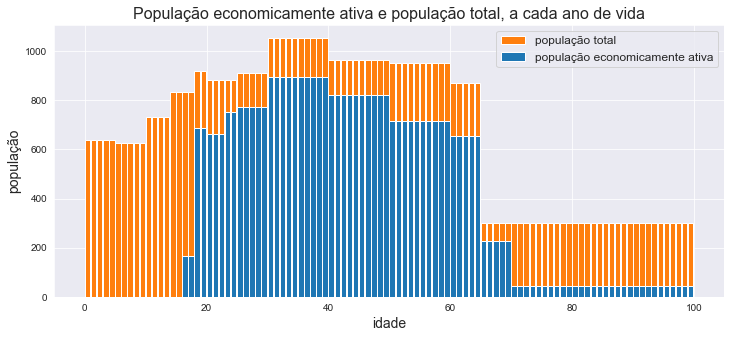

In [22]:
plt.figure(figsize=(12,5))
plt.bar(list(range(idade_max)), num_pop*idades_fracoes,
        width=0.9, align = 'edge', color='tab:orange', label='população total')
plt.bar(list(range(idade_max)), num_pop*pea_idades_fracoes,
        width=0.9, align = 'edge', color='tab:blue', label='população economicamente ativa')
#plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:blue', label='população total')
#plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:blue', label='população total')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'População economicamente ativa e população total, a cada ano de vida', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [23]:
emp_max = 1000
print(f'Tamanho máximo de empresa: {emp_max}')

Tamanho máximo de empresa: 1000


In [24]:
def zipf3(a, c, k_max, k):
    '''
    retorna a fração de indivíduos em empresas de tamanho maior que k.
    '''
    return (((1.0 + k_max/a)/(1.0 + k/a))**c - 1)/((1 + k_max/a)**c - 1.0)

def zipf3_sec(a, c, k_max, k0, k1):
    '''
    retorna a fração de individuos em empresas de tamanho maior ou igual a k0 e menor que k1.
    '''
    return zipf3(a, c, k_max, k0) - zipf3(a, c, k_max, k1)

def zipf3e(a, c, k_max, k):
    '''
    retorna a fração de empresas de tamanho k.
    '''
    return zipf3_sec(a, c, k_max, k-1, k)/k

In [25]:
z3_a = 5.1
z3_c = 0.9
z3_max = emp_max

In [26]:
print(zipf3(z3_a, z3_c, z3_max, 0))
print(zipf3(z3_a, z3_c, z3_max, 1))
print(zipf3_sec(z3_a, z3_c, z3_max, 0, 1))
print(zipf3e(z3_a, z3_c, z3_max, 1))

1.0
0.8498779775590548
0.1501220224409452
0.1501220224409452


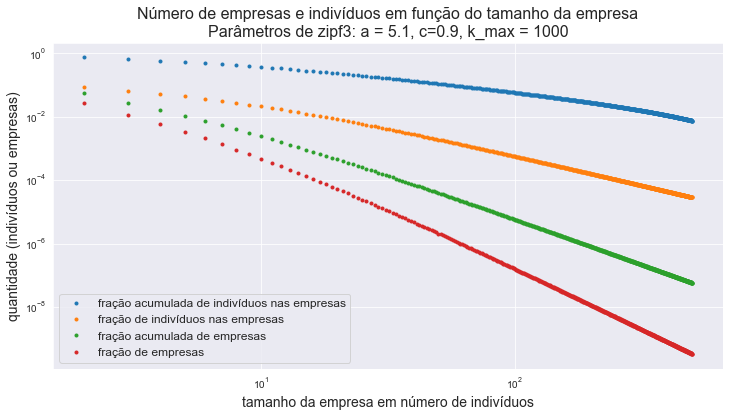

In [56]:
tam_min = 2
tam_max = int(z3_max/2)
tam_z3 = np.array(range(tam_min, tam_max+1))
pop_z3 = zipf3(z3_a, z3_c, z3_max, tam_z3)
emp_z3 = zipf3e(z3_a, z3_c, z3_max, tam_z3)
pop_z3_alt = pop_z3[:-1] - pop_z3[1:]
emp_z3_alt = emp_z3[:-1] - emp_z3[1:]
plt.figure(figsize=(12,6))
plt.plot(tam_z3, pop_z3, 'o', ms=3, label='fração acumulada de indivíduos nas empresas')
plt.plot(tam_z3[:-1], pop_z3_alt, 'o', ms=3, label='fração de indivíduos nas empresas')
plt.plot(tam_z3, emp_z3, 'o', ms=3, label='fração acumulada de empresas')
plt.plot(tam_z3[:-1], emp_z3_alt, 'o', ms=3, label='fração de empresas')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('tamanho da empresa em número de indivíduos', fontsize=14)
plt.ylabel('quantidade (indivíduos ou empresas)', fontsize=14)
plt.title('Número de empresas e indivíduos em função do tamanho da empresa\n'
          + f'Parâmetros de zipf3: a = {z3_a}, c={z3_c}, k_max = {z3_max}', fontsize=16)
plt.show()

In [28]:
def quantifica_empresas_por_tamanho(num_pop, num_pop_emp, tam_min, z3_a, z3_c, z3_max, verbose=False):

    emp_tams_z3 = np.arange(tam_min, z3_max)
    emps_num_z3 = (num_pop_emp*zipf3e(z3_a, z3_c, z3_max, emp_tams_z3)).astype(int)
    emps_num_z3 = emps_num_z3[emps_num_z3>0]
    emp_tams_z3 = np.array(list(range(tam_min, tam_min + len(emps_num_z3))))
    emps_pop_z3 = np.array([(tam_min + k)*emps_num_z3[k] for k in range(len(emps_num_z3))])

    if not len(emp_tams_z3):
        print('Não foi possível distribuir as empresas, tente com outros parâmetros')
    elif verbose:
        print(f'Total da população: {num_pop}')
        print(f'Total da força de trabalho: {num_pop_emp}')
        print(f'Número de tamanhos de empresas: {len(emps_num_z3)}')
        print(f'Número de empresas: {emps_num_z3.sum()}')
        print(f'Tamanhos de empresas: de {emp_tams_z3.min()} a {emp_tams_z3.max()}')
        print(f'Número de indivíduos nas empresas: {emps_pop_z3.sum()}')
        print(f'Média de indivíduos por empresa: {emps_pop_z3.sum()/emps_num_z3.sum()}')
        print('Porcentagem de indivíduos da força de trabalho nas empresas: '
              + f'{100*emps_pop_z3.sum()/num_pop_emp:.1f}%')
        print(f'Distribuição de empresas por tamanho: \n{emps_num_z3}')
        print(f'Distribuição de indivíduos por tamanho de empresa: \n{emps_pop_z3}')
    
    return emp_tams_z3, emps_num_z3, emps_pop_z3

In [29]:
emp_tams_z3, emps_num_z3, emps_pop_z3 = \
    quantifica_empresas_por_tamanho(num_pop, num_pop_emp, tam_min, z3_a, z3_c, z3_max,
                                   verbose=True)

Total da população: 67973
Total da força de trabalho: 39114
Número de tamanhos de empresas: 57
Número de empresas: 5698
Tamanhos de empresas: de 2 a 58
Número de indivíduos nas empresas: 28719
Média de indivíduos por empresa: 5.04018954018954
Porcentagem de indivíduos da força de trabalho nas empresas: 73.4%
Distribuição de empresas por tamanho: 
[2144 1091  646  419  289  209  156  120   94   75   61   50   42   35
   30   26   22   19   17   15   13   12   10    9    8    8    7    6
    6    5    5    4    4    4    3    3    3    3    2    2    2    2
    2    2    1    1    1    1    1    1    1    1    1    1    1    1
    1]
Distribuição de indivíduos por tamanho de empresa: 
[4288 3273 2584 2095 1734 1463 1248 1080  940  825  732  650  588  525
  480  442  396  361  340  315  286  276  240  225  208  216  196  174
  180  155  160  132  136  140  108  111  114  117   80   82   84   86
   88   90   46   47   48   49   50   51   52   53   54   55   56   57
   58]


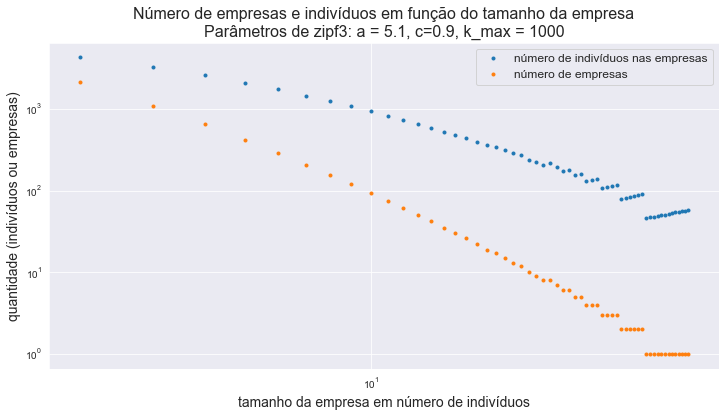

In [30]:
plt.figure(figsize=(12,6))
plt.plot(emp_tams_z3, emps_pop_z3, 'o', ms=3, label='número de indivíduos nas empresas')
plt.plot(emp_tams_z3, emps_num_z3, 'o', ms=3, label='número de empresas')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('tamanho da empresa em número de indivíduos', fontsize=14)
plt.ylabel('quantidade (indivíduos ou empresas)', fontsize=14)
plt.title('Número de empresas e indivíduos em função do tamanho da empresa\n'
          + f'Parâmetros de zipf3: a = {z3_a}, c={z3_c}, k_max = {z3_max}', fontsize=16)
plt.show()

In [31]:
wsc = [0, 6, 11, 21, 51, 101]
nwsc = []
for j in range(1,len(wsc)):
    nwsc.append(emps_pop_z3[wsc[j-1]:wsc[j]].sum())
nwsc.append(emps_pop_z3[wsc[j]:].sum())

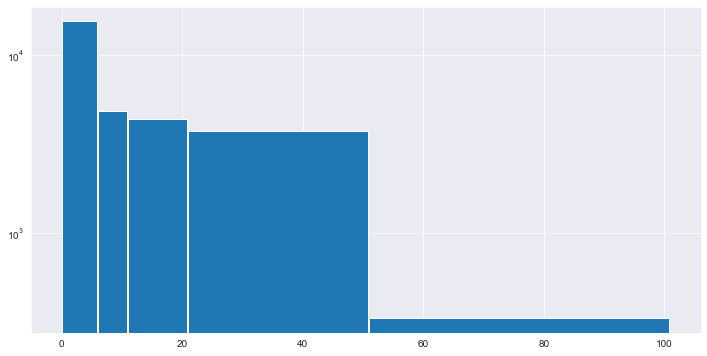

In [32]:
bar_width = [wsc[j] - wsc[j-1] - 0.2 for j in range(1,len(wsc))]
bar_width.append(emp_tams_z3[-1]-wsc[-1])
plt.figure(figsize=(12,6))
plt.bar(wsc, nwsc, bar_width, align='edge')
plt.yscale('log')
plt.show()

In [33]:
%%time
random.seed(1207)
pop_blocos_flat = pop_por_blocos.flatten()
emp_loc = random.choices(list(range(len(pop_blocos_flat))), pop_blocos_flat/num_pop, k=emps_num_z3.sum())

CPU times: user 8.65 ms, sys: 322 µs, total: 8.97 ms
Wall time: 9.02 ms


In [34]:
emp_por_blocos = np.zeros_like(pop_por_blocos)
emp_bloco_pos = list()
emp_tam = list()
k_nivel = 0
for k in range(len(emp_loc)):
    if k >= emps_num_z3[:k_nivel+1].sum():
        k_nivel += 1
    emp_tam.append(tam_min + k_nivel)
    loc = emp_loc[k]
    emp_bloco_pos.append((loc // 83, loc % 83))
    emp_por_blocos[loc // 83, loc % 83] += 1
print(f'Número de blocos alocados: {sum(emp_tam)}')

Número de blocos alocados: 28719


In [35]:
print(f'Total de empresas alocadas: {emp_por_blocos.sum()}')
print(f'Maior concentração de empresas: {emp_por_blocos.max()}')
print(f'(Primeiro) bloco com a maior concentração:')
print(f'({np.argmax(emp_por_blocos) // 83}, {np.argmax(emp_por_blocos) % 83})')

Total de empresas alocadas: 5698
Maior concentração de empresas: 47
(Primeiro) bloco com a maior concentração:
(27, 11)


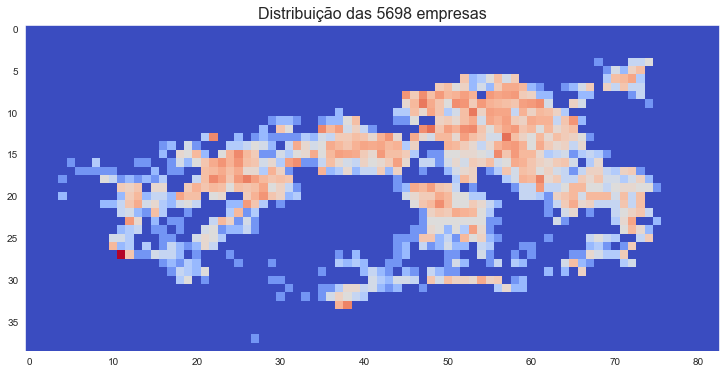

In [36]:
plt.figure(figsize=(15,6))
plt.imshow(np.log(1 + emp_por_blocos), cmap='coolwarm', interpolation='nearest')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_blocos.sum()} empresas', fontsize=16)
plt.show()

### Localização das empresas

Neste primeiro momento, não vou me preocupar em detalhar muito isso.

Vamos considerar a localização das empresas como sendo o centro do bloco em que cada empresa está.

Posteriormente podemos localizá-las aleatoriamente dentro dos blocos, como feito na rede residencial.

### Distribuição da população economicamente ativa nas empresas

- Agora, para cada empresa, vamos alocar indivíduos de acordo com a distância até ela.

- Vamos assumir que temos uma variável com o deslocamento médio dos indivíduos até o trabalho, digamos `emp_desloc_medio_geral`.

- Vamos variar um pouco, essa distância média, seguindo uma distribuição gaussiana em torno dela.

- Posteriormente, podemos variar proporcionalmente ao tamanho da empresa, com empresas maiores exibindo um deslocamento médio maior:

    - $g(k/k_\text{medio})$ distância média de uma empresa de tamanho $k$.
    
    - $g$ crescente
    
    - $(1/N)\sum_k n(k)g(k/k_\text{medio}) = 1$




### Moovit

A reportagem [Moradores do RJ são os que gastam mais tempo em transporte público entre 10 regiões metropolitanas do país](https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/01/15/moradores-do-rj-sao-os-que-gastam-mais-tempo-em-transporte-publico-entre-10-regioes-metropolitanas-do-brasil-mostra-aplicativo.ghtml) menciona uma média de 67 min por viagem, na região metropolitana do Rio de Janeiro. 

O que é mais interessante é a menção ao fato dos dados terem sido obtidos pelo Moovit. Isso significa que os seus dados devem ser, sim, significativos.

Devemos lembrar que, além da distância média, é interessante ajustarmos os dados de deslocamento a alguma distribuição de probabilidades.

É mencionado, pelo menos, que 36% levam entre 1 e 2 horas para chegar ao destino e 11% levam mais de 2 horas.

#### 

O artigo https://www.anpec.org.br/encontro/2014/submissao/files_I/i10-1dc14346dd67760748fefecaac00a05a.pdf dá bem mais detalhes, inclusive por bairros da cidade, baseado na análise do CENSO de 2010.

Veja, também, https://m.sebrae.com.br/Sebrae/Portal%20Sebrae/UFs/RJ/Menu%20Institucional/SEBRAE_EPG_set13_mob_urb_merc_trab_rj.pdf


### Distribuição por bloco

In [37]:
np.arange(0.5, 0.5 + emp_por_blocos.shape[0])

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5])

In [38]:
i = np.arange(0.5, 0.5 + emp_por_blocos.shape[0])
j = np.arange(0.5, 0.5 + emp_por_blocos.shape[1])
jj, ii = np.meshgrid(j,i)
dist =  np.sqrt((jj - 25)**2 + (ii - 15)**2)
a_dist = 2
c_dist = 5
f_dist = lambda dist: 1/(1 + (dist/a_dist)**c_dist)
print(f_dist(dist).min())

3.460219918831722e-08


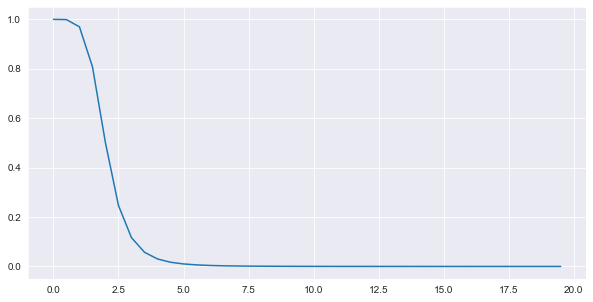

In [39]:
plt.figure(figsize=(10,5))
distancias = np.arange(0, 20, 0.5)
#f_distancias = 1/(1 + (distancias/a_dist)**c_dist)
f_distancias = f_dist(distancias)
plt.plot(distancias, f_distancias)
plt.show()

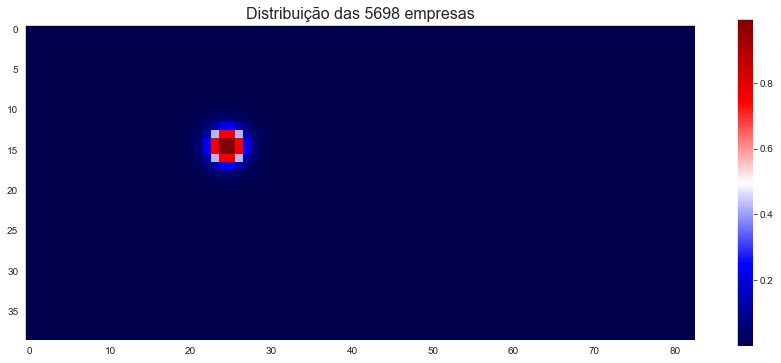

In [40]:
plt.figure(figsize=(15,6))
plt.imshow(f_dist(dist), cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_blocos.sum()} empresas', fontsize=16)
plt.show()

In [41]:
k_dist = f_dist(dist) * pop_por_blocos #/ num_pop
#k_dist /= k_dist.sum()

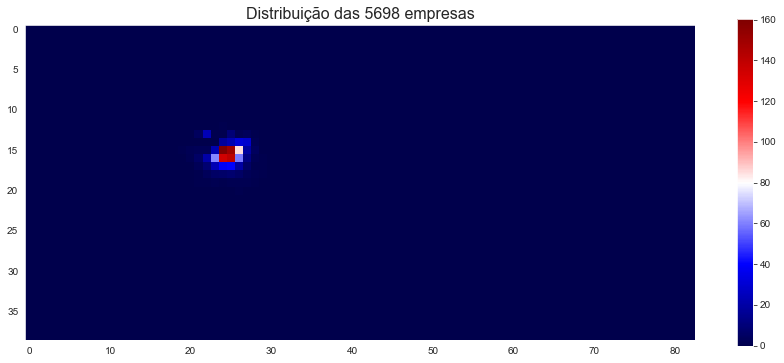

In [42]:
plt.figure(figsize=(15,6))
plt.imshow(k_dist, cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_blocos.sum()} empresas', fontsize=16)
plt.show()

In [43]:
%%time
random.seed(2321)
emp_ind = list()

dens_blocos = pop_por_blocos / num_pop

for k in range(len(emps_num_z3)):
    for j in range(emps_num_z3[k]):
        dist =  np.sqrt((jj - emp_bloco_pos[k+j][1])**2 + (emp_bloco_pos[k+j][0] - 8)**2)
        k_dist = f_dist(dist)*dens_blocos #1/(1 + dist)
#        k_dist *= dens_blocos
        emp_ind.append(
            random.choices(list(range(emp_por_blocos.shape[0]*emp_por_blocos.shape[1])),
                           k_dist.flatten(),
                           k = tam_min + k)
        )
              
print(f'Número de blocos alocados: {sum([len(emp_ind[k]) for k in range(len(emp_ind))])}')   

Número de blocos alocados: 28719
CPU times: user 7.64 s, sys: 67 ms, total: 7.71 s
Wall time: 7.94 s


In [44]:
print(len(emp_bloco_pos)) # bloco em que cada empresa está localizada
print(len(emp_tam)) # tamanho de cada empresa
print(len(emp_ind)) # localização linear do bloco dos indivíduos de cada empresa

5698
5698
5698


In [45]:
%%time
indices = np.array(range(num_pop))
pop_indices = indices[pop_idades > 17]
emp_membros = list()

for j in range(len(emp_tam)):
    membros_j = list()
    for l in emp_ind[j]:
        aux = pop_indices[pop_indices >= pop_blocos_indices[l]]
        candidatos = aux[aux < pop_blocos_indices[l+1]]
        if len(candidatos):
#            pesos = np.array([f_pea_fracoes(idade) for idade in pop_idades[candidatos]])
#            individuo = random.sample(candidatos, pesos)
            individuo = random.choice(candidatos)
            membros_j.append(individuo)
            pop_indices = pop_indices[pop_indices != individuo]
    emp_membros.append(membros_j)

CPU times: user 6.02 s, sys: 1.37 s, total: 7.39 s
Wall time: 7.5 s


In [46]:
type(pesos)

NameError: name 'pesos' is not defined

In [ ]:
f_pea_fracoes = lambda idade: pea_idades_fator[idade]
print(f_pea_fracoes(24))
print(pop_idades[candidatos])
print([f_pea_fracoes(idade) for idade in pop_idades[candidatos]])

In [ ]:
m = 0
for j in range(len(emp_tam)):
    if len(emp_membros[j]) < emp_tam[j]:
#        print(f'Empresa {j} com {emp_tam[j] - len(emp_membros[j])} vagas não preenchidas')
        m += emp_tam[j] - len(emp_membros[j])
    elif len(emp_membros[j]) > emp_tam[j]:
        print(f'Ops em j={j}')
print(f'Total de {m} empresas com vagas não preenchidas')

In [ ]:
for j in range(len(emp_tam)):
    faltam = emp_tam[j] - len(emp_membros[j])
    if faltam > 0:
        membros_j = random.choices(pop_indices, k=faltam)
#        print(membros_j)
        emp_membros[j] += membros_j
        if emp_tam[j] - len(emp_membros[j]) > 0:
            print(f'Não completou em j={j}')
            print(emp_tam[j])
            print(len(emp_membros[j]))
            print(faltam)
            print(membros_j)
            print(len(emp_membros[j]))
            print()
        pop_indices = pop_indices[pop_indices != individuo]

In [ ]:
print(f'População total: {num_pop}')
print(f'População em idade ativa: {num_pop_emp}')
print(f'Número de pessoas alocadas: {sum([len(emp) for emp in emp_membros])}')
print(f'População em idade ativa não alocada: {num_pop_emp - sum([len(emp) for emp in emp_membros])}')
print(f'Número de vagas: ')

### Lista de indivíduos por empresa

O processo abaixo nos gerou a lista `emp_membros`, em que cada membro da lista representa uma empresa e cujo valor é uma outra lista indicando todos os indivíduos alocados nessa empresa.

### Pirâmide da população economicamente ativa

Primeiro justamos em uma lista os índices de todos os indivíduos alocados em alguma empresa

In [ ]:
pop_empresas = []
for emp in emp_membros:
    pop_empresas += emp
print(f'População economicamente ativa: {len(pop_empresas)}')

#### Visulizando a pirâmide

Agora podemos exibir a pirâmide.

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:blue',
         label='populacional total')
plt.hist(pop_idades[pop_empresas], bins = list(range(idade_max+1)), color='tab:orange',
         label='populacional economicamente ativa')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Gerando o grafo da rede empresarial



In [ ]:
%%time
G_e = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

for membros in emp_membros:
    if len(membros) > 1:
        G_e.add_edges_from([(i,j) for i in membros for j in membros if i < j])

### Visualização da rede

In [ ]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

In [ ]:
%%time
G_e_parte = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

emp_membros_10mais = [membros for membros in emp_membros if len(membros)>10]
emp_membros_parte = random.sample(emp_membros_10mais, 1)
for membros in emp_membros_parte:
    if len(membros) > 1:
        G_e_parte.add_edges_from([(i,j) for i in membros for j in membros if i < j])
for membros in emp_membros_parte:
    print(f'Empresa de tamanho: {len(membros)}')

In [ ]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e_parte, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020. (Free Download)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2).

<!--NAVIGATOR-->

---
[<- Construção de cenários: definindo as idades](22.00.Aula-Construindo_Cenarios_Distribuicao_Idades.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 